In [1]:
from collections import Counter
from itertools import product
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from mlresearch.utils import set_matplotlib_style, parallel_loop
from mlresearch.utils._check_pipelines import check_random_states
from recgame.environments import FairEnvironment
from functions import (
    fairness_metrics_viz_data, 
    biased_data_generator_hc, 
    get_scaler_hc, 
    fairness_metrics_overall, 
    fairness_metrics_overall_visualizations, 
    fairness_metrics_per_time_step, 
    fairness_metrics_viz_data,
    IgnoreGroupRanker,
    IgnoreGroupLR
)

set_matplotlib_style(32, **{"font.family":"Times"})

# NFeatureRecourse ignoring categorical feature

In [2]:
import warnings
from typing import Union
import numpy as np
from recgame.recourse.base import BaseRecourse


class NFeatureRecourse(BaseRecourse):
    """TODO: Add documentation."""

    def __init__(
        self,
        model,
        n_features: int = None,
        threshold=0.5,
        categorical: Union[list, np.ndarray] = None,
        immutable: Union[list, np.ndarray] = None,
        step_direction: dict = None,
        y_desired: Union[int, str] = 1,
    ):
        super().__init__(
            model=model,
            threshold=threshold,
            categorical=categorical,
            immutable=immutable,
            step_direction=step_direction,
            y_desired=y_desired,
        )

        # if categorical is not None and categorical != []:
        #     raise TypeError(
        #         "NFeatureRecourse does not work with categorical features. Consider "
        #         "using a different recourse method."
        #     )

        self.n_features = n_features

    def _counterfactual(self, agent, action_set):
        agent_original = agent.copy()

        # Do not change if the agent is over the threshold
        if self.model.predict_proba(agent.to_frame().T)[0, -1] >= self.threshold:
            return agent_original

        categorical_vals = agent_original[self.categorical].values
        agent = agent_original.drop(self.categorical).copy()

        intercept, coefficients, model = self._get_coefficients()

        # Get base vector
        base_vector = coefficients.copy().squeeze()
        n_features = (
            base_vector.shape[0] if self.n_features is None else self.n_features
        )

        is_usable = np.array(
            [
                action_set[col].step_direction in [np.sign(coeff), 0]
                and action_set[col].actionable
                for col, coeff in zip(agent.index, base_vector)
            ]
        )
        base_vector[~is_usable] = 0

        # Use features with highest contribution towards the threshold
        rejected_features = np.argsort(np.abs(base_vector))[:-n_features]
        base_vector[rejected_features] = 0

        base_vector = base_vector / np.linalg.norm(base_vector)
        multiplier = (-intercept - np.dot(agent.values, coefficients.T)) / np.dot(
            base_vector, coefficients.T
        )
        counterfactual = agent + multiplier * base_vector
                        
        lb, ub = np.array(action_set.lb), np.array(action_set.ub)
        
        lb = lb[action_set.df.name.values != self.categorical]
        ub = ub[action_set.df.name.values != self.categorical]

        # Check if base_vector adjustments are not generating invalid counterfactuals
        for i in range(agent.shape[0]):
            # Adjust vector according to features' bounds
            lb_valid = counterfactual >= lb
            ub_valid = counterfactual <= ub

            if lb_valid.all() and ub_valid.all():
                break

            if not lb_valid.all():
                # Fix values to its lower bound
                idx = np.where(~lb_valid)[0]
                agent[idx] = lb[idx]
                base_vector[idx] = 0

            if not ub_valid.all():
                # Fix values to its upper bound
                idx = np.where(~ub_valid)[0]
                agent[idx] = ub[idx]
                base_vector[idx] = 0

            if (base_vector == 0).all():
                # All max/min boundaries have been met.
                counterfactual = agent
            else:
                
                # Redefine counterfactual after adjusting the base vector
                base_vector = base_vector / np.linalg.norm(base_vector)
                multiplier = (
                    -intercept - np.dot(agent.values, coefficients.T)
                ) / np.dot(base_vector, coefficients.T)
                counterfactual = agent + multiplier * base_vector

        lb_valid = counterfactual >= lb
        ub_valid = counterfactual <= ub
        if not (lb_valid.all() and ub_valid.all()):
            warnings.warn(
                "Could not generate a counterfactual to reach the desired threshold."
            )

            
        for cat_feat, value in zip(self.categorical, categorical_vals):
            counterfactual[cat_feat] = value


        return counterfactual


# Define functions

In [6]:
from recgame.environments._behavior_functions import ContinuousFlexible


class ContinuousConstantCustom(ContinuousFlexible):
    """Applies continuous adaptation with constant effort."""
    bias_factor_effort_g0 = 0
    bias_factor_effort_g1 = 0
    
    def effort(self, X, global_adaptation):
        """
        Applies constant effort.

        Returns effort rate.
        """
        # Fetch environment variables
        rng = self.environment._rng

        current_effort = (
            self.environment.effort_ if hasattr(self.environment, "effort_") else None
        )

        df_new = (
            self.environment._new_agents
            if hasattr(self.environment, "_new_agents")
            else X
        )

        counts = Counter(df_new["groups"])
        
        x0 = np.abs(rng.normal(0+self.bias_factor_effort_g0, 1, counts[0]))
        x1 = np.abs(rng.normal(0+self.bias_factor_effort_g1, 1, counts[1]))
        
        x = df_new["groups"].copy()
        x.loc[x==0] = x0
        x.loc[x==1] = x1
        x = x.values

        effort_rate = x * global_adaptation / 20
        effort_rate = pd.Series(effort_rate, index=df_new.index)
        effort_rate = pd.concat([current_effort, effort_rate])

        # return pd.Series(effort_rate, index=X.index)
        return effort_rate

    
def behavior_function_generator(bias_factor_effort_g0, bias_factor_effort_g1):
    behav = ContinuousConstantCustom
    behav.bias_factor_effort_g0 = bias_factor_effort_g0
    behav.bias_factor_effort_g1 = bias_factor_effort_g1
    return behav

# Simulation function

In [12]:
def _meta_simulation(params):
    """
    N_AGENTS
    N_CONTINUOUS
    N_LOANS
    BIAS_FACTOR
    ADAPTATION
    NEW_AGENTS
    RNG_SEED
    """ 
    N_AGENTS, N_CONTINUOUS, N_LOANS, BIAS_FACTOR, ADAPTATION, NEW_AGENTS, BIAS_EFFORT, RNG_SEED = params
    
    rng = np.random.default_rng(RNG_SEED)
    
    scaler = get_scaler(
        n_agents=10_000, 
        n_continuous=N_CONTINUOUS, 
        bias_factor=BIAS_FACTOR, 
        random_state=rng
    )

    def env_biased_data_generator(n_agents):
        return biased_data_generator(n_agents, n_continuous=N_CONTINUOUS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng)[0]
    
    df, y = biased_data_generator(N_AGENTS, n_continuous=N_CONTINUOUS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng)
    categorical = ["groups"]
    
    model = IgnoreGroupLR(categorical, random_state=RNG_SEED).fit(df, y)
    model.coef_ = np.array([[2, 2]])
    model.intercept_ = np.array([-1])
    
    # Define the necessary components to run simulation
    recourse = NFeatureRecourse(model, categorical=["groups"], immutable=["groups"])  # , random_state=RNG_SEED)
    recourse.set_actions(df)
    recourse.action_set_.lb = [-0.1, -0.1, 0]
    recourse.action_set_.ub = [1.1, 1.1, 1]
    
    environment = FairEnvironment(
        X=df,
        recourse=recourse,
        group_feature="groups",
        data_source_func=env_biased_data_generator,
        threshold=N_LOANS,
        threshold_type="absolute",
        adaptation=ADAPTATION,
        behavior_function=behavior_function_generator(*BIAS_EFFORT),
        growth_rate=NEW_AGENTS,
        growth_rate_type="absolute",
        random_state=RNG_SEED,
    )
    
    try:
        environment.simulate(20)
        return (
            {
                "N_AGENTS": N_AGENTS,
                "N_CONTINUOUS": N_CONTINUOUS,
                "N_LOANS": N_LOANS,
                "BIAS_FACTOR": BIAS_FACTOR,
                "ADAPTATION": ADAPTATION,
                "NEW_AGENTS": NEW_AGENTS,
                "BIAS_EFFORT": BIAS_EFFORT,
                "RNG_SEED": RNG_SEED,
    
            }, 
            environment,
        )
    except:
        print(f"Experiment failed with params {params}\nRetrying with a new random seed.")
        params["RNG_SEED"] = params["RNG_SEED"]+1
        return _meta_simulation(params)
    


# Experiments

In [13]:
N_AGENTS = [100]
N_CONTINUOUS = [2]
N_LOANS = [10]
BIAS_FACTOR = [0,1,2,3]
ADAPTATION = [.5]
NEW_AGENTS = [10]
RNG_SEED = check_random_states(42, 5)
BIAS_EFFORT = ([1, 0],)

# EXP 1

In [14]:
results = parallel_loop(
    _meta_simulation, 
    list(product(
        N_AGENTS,
        N_CONTINUOUS,
        N_LOANS,
        BIAS_FACTOR,
        ADAPTATION,
        NEW_AGENTS,
        BIAS_EFFORT,
        RNG_SEED,
    )),
    n_jobs=-1,
    progress_bar=True
)

Output()

In [15]:
# fair_res = []
# for hyperparams, environment in results:
#     bias = hyperparams["BIAS_FACTOR"]
#     fairness_res = fairness_metrics(environment, filter_feature="groups", bins=10, advantaged_pop=1)
#     fairness_res["Merit"] = bias
#     fair_res.append(fairness_res)

In [16]:
# pd.DataFrame(np.mean(ai_etrs, axis=0), columns=ai_etrs[0].columns, index=ai_etrs[0].index)

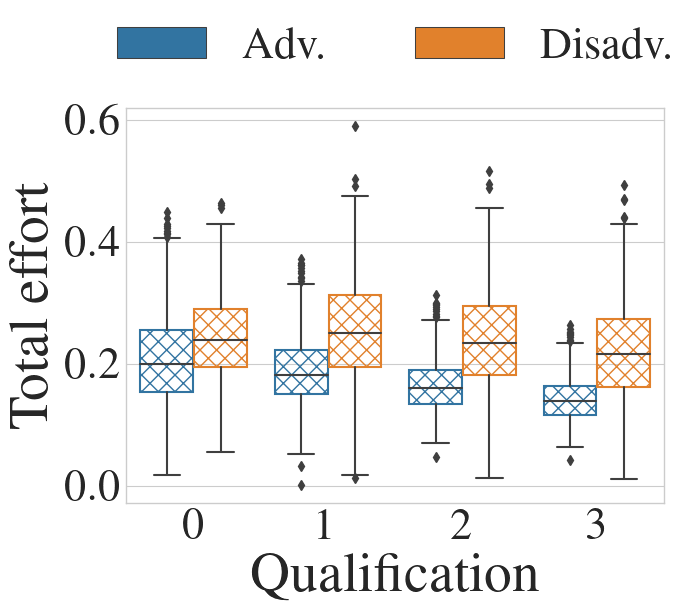

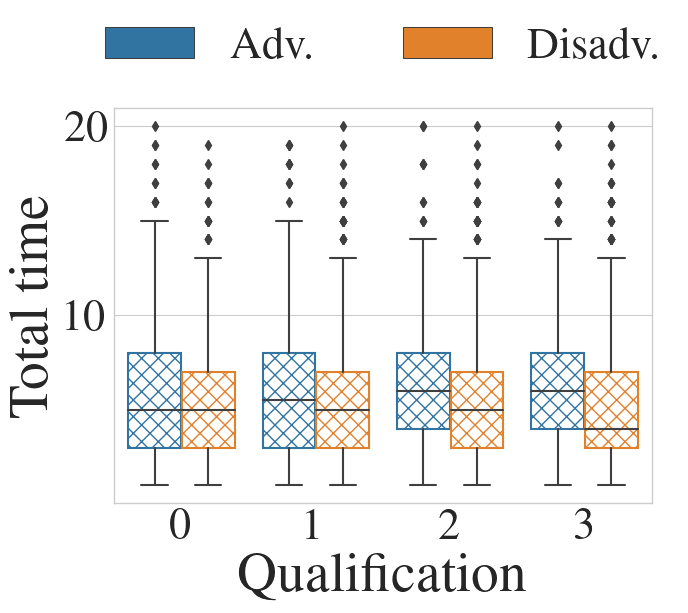

In [73]:
metrics_dfs = []
for params, environment in results:
    ai_etr = fairness_metrics_viz_data(environment)
    metrics_dfs.append((params, ai_etr))
    
ai_etrs_all = []
for bf in BIAS_FACTOR:
    ai_etrs = [df for p, df in metrics_dfs if p["BIAS_FACTOR"] == bf]
    ai_etrs = pd.concat(ai_etrs)
    ai_etrs["qualification"] = bf
    ai_etrs_all.append(ai_etrs)

agents_data_n_runs = pd.concat(ai_etrs_all)

agents_data_n_runs["groups2"] = agents_data_n_runs["groups"].apply(lambda x: "Adv." if x == 1 else "Disadv.")

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="total_effort", hue="groups2")

hatches = ['//', 'xx'] # , 'xx']
# select the correct patches
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    # patch.set_hatch(hatch)
    patch.set_hatch("xx")
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

ax.set_xlabel("Qualification")
ax.set_ylabel("Total effort")

sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False
)
plt.savefig(
    f"MM_B10_total_effort.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()



ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="time_for_recourse", hue="groups2")

hatches = ['//', 'xx'] # , 'xx']
# select the correct patches
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    # patch.set_hatch(hatch)
    patch.set_hatch("xx")
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

ax.set_xlabel("Qualification")
ax.set_ylabel("Total time")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
plt.savefig(
    f"MM_B10_time_for_recourse.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [18]:
m1 = agents_data_n_runs.groupby(["qualification", "groups"]).mean(numeric_only=True)[["time_for_recourse", "total_effort"]]

def apply_transf(df):
    df = df.set_index("groups")
    res_ = {}
    res_["time_to_recourse_difference"] = (df.loc[0, "time_for_recourse"] - df.loc[1, "time_for_recourse"])
    res_["effort_to_recourse_ratio"] = (df.loc[0, "total_effort"] / df.loc[1, "total_effort"])
    return pd.Series(res_)

m1.reset_index().groupby("qualification").apply(apply_transf)

,time_to_recourse_difference,effort_to_recourse_ratio
qualification,,
0,0.051390,1.186024
1,-0.346000,1.335643
2,-0.578914,1.447064
3,-0.804946,1.557516


# EXP 2

In [19]:
BIAS_EFFORT2 = ([0, 1],) # [0, 0], 

In [20]:
results2 = parallel_loop(
    _meta_simulation, 
    list(product(
        N_AGENTS,
        N_CONTINUOUS,
        N_LOANS,
        BIAS_FACTOR,
        ADAPTATION,
        NEW_AGENTS,
        BIAS_EFFORT2,
        RNG_SEED,
    )),
    n_jobs=-1,
    progress_bar=True
)

Output()

In [21]:
# fair_res = []
# for hyperparams, environment in results2:
#     bias = hyperparams["BIAS_FACTOR"]
#     fairness_res = fairness_metrics(environment, filter_feature="groups", bins=10, advantaged_pop=1)
#     fairness_res["Merit"] = bias
#     fair_res.append(fairness_res)

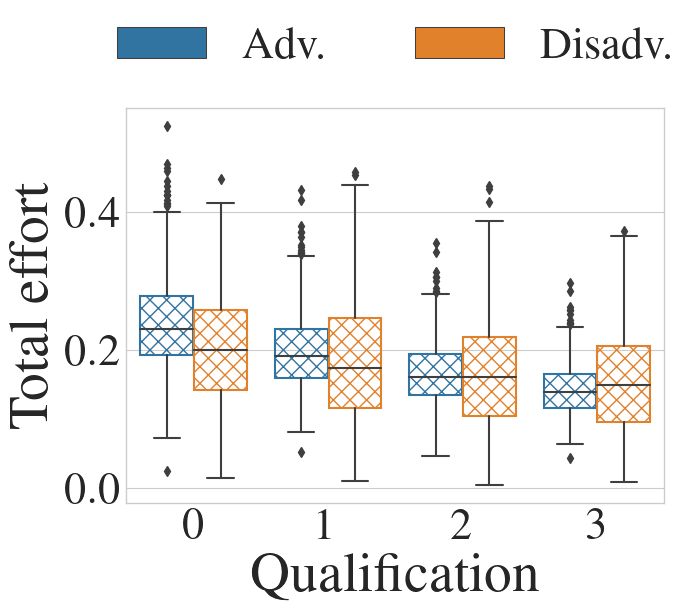

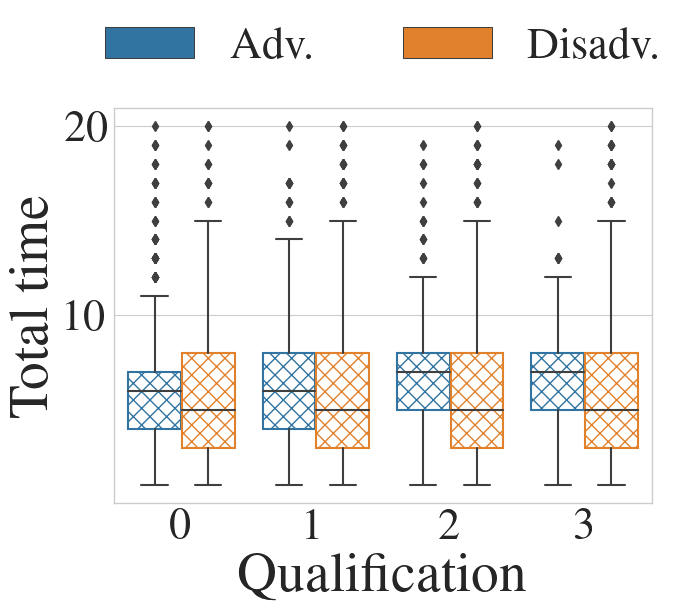

In [75]:
metrics_dfs = []
for params, environment in results2:
    ai_etr = fairness_metrics_viz_data(environment)
    metrics_dfs.append((params, ai_etr))
    
ai_etrs_all = []
for bf in BIAS_FACTOR:
    ai_etrs = [df for p, df in metrics_dfs if p["BIAS_FACTOR"] == bf]
    ai_etrs = pd.concat(ai_etrs)
    ai_etrs["qualification"] = bf
    ai_etrs_all.append(ai_etrs)

agents_data_n_runs = pd.concat(ai_etrs_all)

agents_data_n_runs["groups2"] = agents_data_n_runs["groups"].apply(lambda x: "Adv." if x == 1 else "Disadv.")

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="total_effort", hue="groups2")

hatches = ['//', 'xx'] # , 'xx']
# select the correct patches
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    # patch.set_hatch(hatch)
    patch.set_hatch("xx")
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

ax.set_xlabel("Qualification")
ax.set_ylabel("Total effort")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False
)
plt.savefig(
    f"MM_B01_total_effort.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()



ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="time_for_recourse", hue="groups2")

hatches = ['//', 'xx'] # , 'xx']
# select the correct patches
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    # patch.set_hatch(hatch)
    patch.set_hatch("xx")
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

ax.set_xlabel("Qualification")
ax.set_ylabel("Total time")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
plt.savefig(
    f"MM_B01_time_for_recourse.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [23]:
m2 = agents_data_n_runs.groupby(["qualification", "groups"]).mean(numeric_only=True)[["time_for_recourse", "total_effort"]]

def apply_transf(df):
    df = df.set_index("groups")
    res_ = {}
    res_["time_to_recourse_difference"] = (df.loc[0, "time_for_recourse"] - df.loc[1, "time_for_recourse"])
    res_["effort_to_recourse_ratio"] = (df.loc[0, "total_effort"] / df.loc[1, "total_effort"])
    return pd.Series(res_)

m2.reset_index().groupby("qualification").apply(apply_transf)

,time_to_recourse_difference,effort_to_recourse_ratio
qualification,,
0,-0.272202,0.837287
1,-0.539306,0.926218
2,-0.708857,0.997663
3,-0.794687,1.082497


# EXP 3

In [24]:
BIAS_EFFORT3 = ([0, 0],)

In [25]:
results3 = parallel_loop(
    _meta_simulation, 
    list(product(
        N_AGENTS,
        N_CONTINUOUS,
        N_LOANS,
        BIAS_FACTOR,
        ADAPTATION,
        NEW_AGENTS,
        BIAS_EFFORT3,
        RNG_SEED,
    )),
    n_jobs=-1,
    progress_bar=True
)

Output()

In [26]:
# fair_res = []
# for hyperparams, environment in results:
#     bias = hyperparams["BIAS_FACTOR"]
#     fairness_res = fairness_metrics(environment, filter_feature="groups", bins=10, advantaged_pop=1)
#     fairness_res["Merit"] = bias
#     fair_res.append(fairness_res)

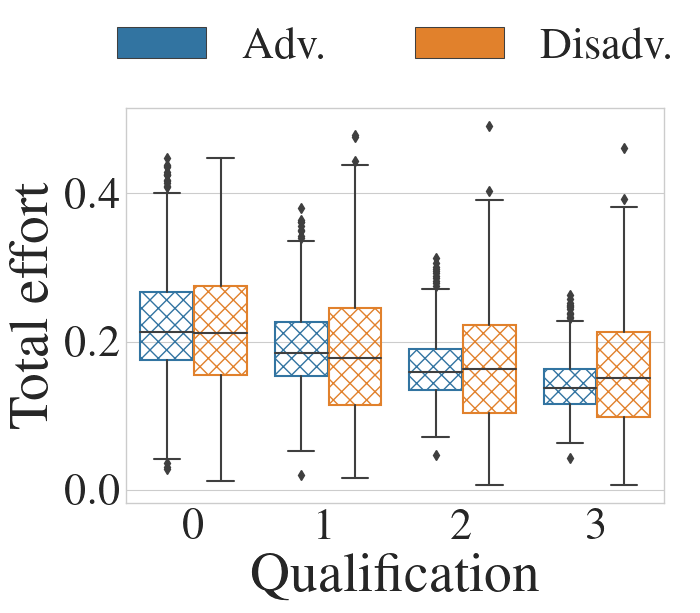

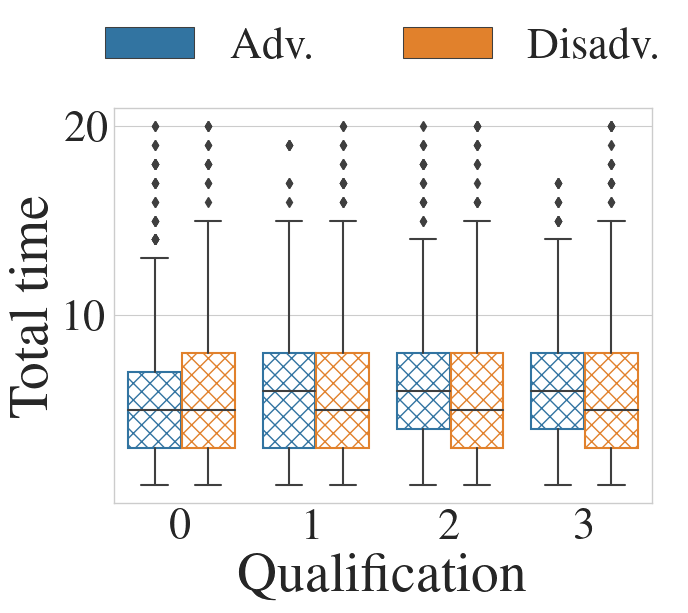

In [76]:
metrics_dfs = []
for params, environment in results3:
    ai_etr = fairness_metrics_viz_data(environment)
    metrics_dfs.append((params, ai_etr))
    
ai_etrs_all = []
for bf in BIAS_FACTOR:
    ai_etrs = [df for p, df in metrics_dfs if p["BIAS_FACTOR"] == bf]
    ai_etrs = pd.concat(ai_etrs)
    ai_etrs["qualification"] = bf
    ai_etrs_all.append(ai_etrs)

agents_data_n_runs = pd.concat(ai_etrs_all)

agents_data_n_runs["groups2"] = agents_data_n_runs["groups"].apply(lambda x: "Adv." if x == 1 else "Disadv.")

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="total_effort", hue="groups2")

hatches = ['//', 'xx'] # , 'xx']
# select the correct patches
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    # patch.set_hatch(hatch)
    patch.set_hatch("xx")
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

ax.set_xlabel("Qualification")
ax.set_ylabel("Total effort")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False
)
plt.savefig(
    f"MM_B00_total_effort.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="time_for_recourse", hue="groups2")

hatches = ['//', 'xx'] # , 'xx']
# select the correct patches
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    # patch.set_hatch(hatch)
    patch.set_hatch("xx")
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

ax.set_xlabel("Qualification")
ax.set_ylabel("Total time")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
plt.savefig(
    f"MM_B00_time_for_recourse.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()


In [28]:
m3 = agents_data_n_runs.groupby(["qualification", "groups"]).mean(numeric_only=True)[["time_for_recourse", "total_effort"]]

def apply_transf(df):
    df = df.set_index("groups")
    res_ = {}
    res_["time_to_recourse_difference"] = (df.loc[0, "time_for_recourse"] - df.loc[1, "time_for_recourse"])
    res_["effort_to_recourse_ratio"] = (df.loc[0, "total_effort"] / df.loc[1, "total_effort"])
    return pd.Series(res_)

m3.reset_index().groupby("qualification").apply(apply_transf)

,time_to_recourse_difference,effort_to_recourse_ratio
qualification,,
0,0.198504,0.970666
1,-0.128820,0.972493
2,-0.494529,1.017931
3,-0.518678,1.112163


# 1st PAGE VIZ - 

In [64]:
QUALIFICATION = 1

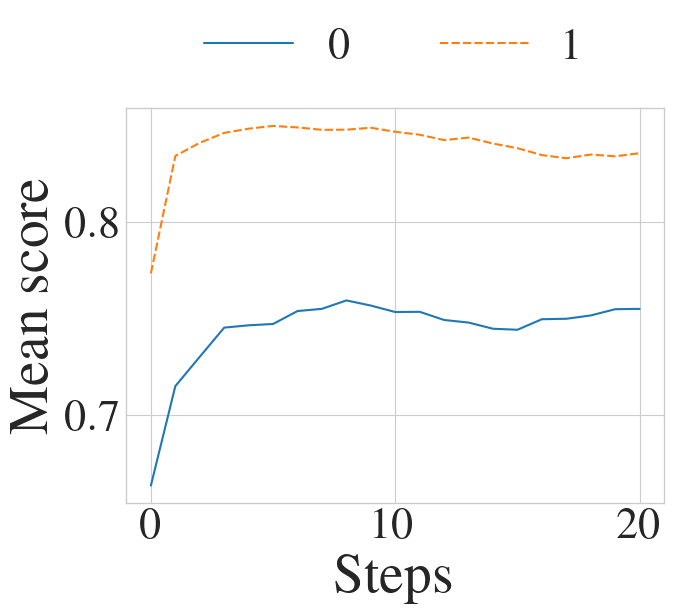

In [65]:
scores_dfs = []
for params, environment in results:
    if params["BIAS_FACTOR"] == QUALIFICATION:
        scores = [ 
            pd.concat(
                [
                    environment.metadata_[step]["score"].rename("score"), 
                    environment.metadata_[step]["X"]["groups"],
                    pd.Series(np.ones(environment.metadata_[step]["score"].shape), name="step") * step
                ], 
                axis=1
            ).groupby("groups").mean()
            for step in environment.metadata_.keys()
        ]
        
        scores = pd.concat(scores).reset_index()
        scores["groups"] = scores["groups"].astype(int)
        scores["step"] = scores["step"].astype(int)
        scores = scores.pivot(index="step", columns="groups", values="score").reset_index()
        scores.columns.rename(None, inplace=True)
        scores_dfs.append(scores)
        
scores_dfs_exp1 = pd.DataFrame(np.mean(scores_dfs, axis=0), columns=scores_dfs[0].columns, index=scores_dfs[0].index)
scores_dfs_exp1["step"] = scores_dfs_exp1["step"].astype(int)
scores_dfs_exp1 = scores_dfs_exp1.set_index("step")
ax = sns.lineplot(scores_dfs_exp1)
ax.set_xlabel("Steps")
ax.set_ylabel("Mean score")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

# Draft

In [77]:
agents_data_n_runs

,entered_step,n_adaptations,favorable_step,original_score,final_score,n_failures,groups,time_for_recourse,total_effort,qualification,groups2
0,0,5,5.0,0.746447,0.892557,0,1,5.0,0.146110,0,Adv.
1,0,2,2.0,0.697447,0.967705,1,0,2.0,0.270257,0,Disadv.
2,0,9,9.0,0.629493,0.967705,1,1,9.0,0.338212,0,Adv.
3,0,1,1.0,0.737993,0.937738,0,1,1.0,0.199744,0,Adv.
4,0,5,5.0,0.704966,0.952537,0,0,5.0,0.247571,0,Disadv.
...,...,...,...,...,...,...,...,...,...,...,...
253,16,2,20.0,0.858543,0.967705,1,1,4.0,0.109162,3,Adv.
257,16,4,20.0,0.818276,0.967705,0,1,4.0,0.149428,3,Adv.
259,16,4,20.0,0.583123,0.709410,0,0,4.0,0.126287,3,Disadv.
266,17,3,20.0,0.501530,0.710626,0,0,3.0,0.209097,3,Disadv.
